In [1]:
# !pip3 install scikit-learn==0.24.1

# Python Data Science Tools Overview

## Analysis goals 

We're going to build a model that classifies plants by species based on their flower measurements. We're hoping to find a set of flower measurements that are good at discriminating between species.

--- 

# Table of contents

## [0. Load packages](#pkg)

## [1. Load Data](#load)

### [1.1 Load Data From a Google Drive Mount](#gdrive)

### [1.2 Load Data From a Google Sheet](#gsheet)

### [1.2 Load Data From Your Computer](#local)

### [1.3 Load Data From GitHub](#github)

## [2. Describe Data](#describe)

### [2.1 Describe Data Structure](#structure)

### [2.2 Describe Data Types](#types)

### [2.3 Visual Descriptions](#graphs)

### [2.4 Data Iterables](#iter)
    
## [3. Clean Data](#clean)

### [3.1 Clean Messy Data](#mess)
    
### [3.2 Describe Missing Data](#miss)
    
#### [3.2.1 Missing Data Can Have Meaning](#mean)

#### [3.2.2 Missing Data vs Zero](#zero)

#### [3.2.3 Find Missing Data by Row](#row)

#### [3.3.4 Describe Distribution of Missing Data](#distr)

### [3.3 Handle Missing Data](#handle)

#### [3.3.1 Ignore Missing Data](#ignore)

#### [3.3.2 Interpolate Missing Data](#interp)

#### [3.3.3 Remove Missing Data](#remove)

## [4. Classification](#class)

### [4.1 Class Balance](#balance)

### [4.2 Measure Standardization](#std)

### [4.3 Multinomial Logistic Regression](#multi)

#### [4.3.1 Fit the Model](#fit1)

#### [4.3.2 Evaluate the Model: Accuracy](#acc)

### [4.4 One-vs-Rest Regression](#ovr)

#### [4.4.1 Fit the Model](#fit2)

#### [4.4.2 Evaluate the Model: Reciever-Operator Criterion](#roc)


# 0. Load packages into notebook namespace <a name="pkg"></a>

This workbook relies on data manipulation, plotting, and machine learning packages. These packages are pre-installed on Google Colab virtual machines, but must be imported before use in the notebook.



In [1]:
from platform import python_version
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.datasets import load_iris

In [2]:
print('The current Python version is {}'.format(python_version()))
print('The current pandas version is {}'.format(pd.__version__))
print('The current numpy version is {}'.format(np.__version__))
print('The current matplotlib version is {}'.format(matplotlib.__version__))
print('The current sklearn version is {}'.format(sk.__version__))

The current Python version is 3.7.10
The current pandas version is 1.1.5
The current numpy version is 1.19.5
The current matplotlib version is 3.2.2
The current sklearn version is 0.22.2.post1


# 1. Load data <a name="load"></a>

We will work with an example dataset that describes flowers from several different plant species. The "iris" dataset is commonly used for data science and machine learning training. This dataset is approximately 3.8kb and will fit in memory.

There are multiple ways to load data depending on (1) where the data are stored and (2) what format the data are in. We will explore a couple of different techniques for loading "iris" data.

## 1.1 Load text data from Google Drive mount <a name="gdrive"></a>

Google Colab can access files saved in your Google Drive, which makes loading some file types very straightforward. You must mount your Google Drive to the virtual machine running the Colab Notebook; after this is complete you will be able to browse files and load supported file types with Pandas.

Supported file types include `.csv` (comma separated values) using the `pd.read_csv()` method, or `.txt` files that have standard character separation for columns and rows using the `pd.read_table()` method.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data in the `.csv` format can be loaded with the `pd.read_csv()` function, which expects a comma (`","`) to separate columns and a newline character to separate rows.

In [4]:
iris_drive_csv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/iris.csv')

Data in the `.txt` format can be loaded with the `pd.read_table()` function.  The default column separating character is a tab (`"\t"`), but if your data had a different column separating character you could indicate that with the `sep` argument. Newline characters separate rows.

In [5]:
iris_drive_table = pd.read_table('/content/drive/MyDrive/Colab Notebooks/iris.txt', sep='\t')

## 1.2 Load data from a Google Sheet file with the Google Sheets API <a name="*gsheet*"></a>

If your data are saved in Google Sheets, there are a few extra steps. Pandas does not support the `.gsheet` format, so even if your Google Drive is mounted to your notebook virtual machine, you won't be able to access Google Sheets files directly (that I've found so far...).

Instead, you'll need to authorize Google Colab to access your Google Drive through an API (rather than the mounted directories), and then use the Google Sheets API via the package `gspread` to load your data. This is very similar to what you would do if you were running a local Jupyter notebook (instead of running the notebook in Colab).

After you've authenticated Google Colab's access to your Google Drive files, you will open the `.gsheet` file you want and convert it to a Pandas dataframe.

In [6]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [7]:
iris_gsheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dxgYstbQt0HRrPu7J4sZD60e_beybGths6XVzSpoTlw/edit?usp=sharing')

iris_gsheet_data = iris_gsheet.worksheet('iris')

iris_gsheet_df = pd.DataFrame(iris_gsheet_data.get_all_records()).astype(
    {
        'sepal_length': float, 'sepal_width': float, 'petal_length': float, 'petal_width': float, 'species': str
    }
)

## 1.3 Load data from your computer <a name="local"></a>

If you have a file saved on your computer that you'd like to work with in Colab, you can upload it to Google Drive directly from your Colab Notebook and then convert to a Pandas dataframe.

In [9]:
from google.colab import files
uploaded = files.upload()

Saving iris.csv to iris (1).csv


In [10]:
import io
iris_upload = pd.read_csv(io.StringIO(uploaded['iris.csv'].decode('utf-8')))

### 1.4 Load data from GitHub <a name="github"></a>

Collaborative software projects typically use version control to track changes in software; `git` is a popular version control tool and GitHub is an online service for hosting remote `git` repositories. Code and small datasets are often made publicly available through GitHub, and we can load data directly from a GitHub URL using Pandas:

In [11]:
iris_github = pd.read_csv('https://raw.githubusercontent.com/kellypierce/python_data_science/master/iris.csv')

## 2. Describe data <a name="describe"></a>

We will proceed with two files loaded from GitHub.

As demonstrated earlier, we can load a `.csv` file directly from GitHub with the appropriate URL:

In [13]:
iris = pd.read_csv('https://raw.githubusercontent.com/kellypierce/python_data_science/master/iris.csv')

If you had a larger dataset that wouldn't fit in memory, you could read it in chunks. The `chunksize=` argument to `pd.read_csv()` determines the number of rows read at a time. When you use the `chunksize=` argument, `pd.read_csv()` returns an iterable. (This is more useful for local data or data in Google Drive because GitHub doesn't support storage of really large data files, but we're using a small dataset simply as an example.)

In [14]:
iris_chunks = pd.read_csv('https://raw.githubusercontent.com/kellypierce/python_data_science/master/iris.csv', chunksize=10)

## 2.1 Describe data structure <a name="structure"></a>

We now have two example data structures loaded:

- `iris`, a pandas dataframe
- `iris_chunks`, an iterable object comprised of small dataframe subsets

First we'll expore the `iris` dataframe.

Inspect the first several rows in the dataframe:

In [15]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


The `.head()` method displays the first 5 rows of the dataframe.

The column on the left, without a header, represents the "index" of the dataframe. Note that indexing starts at 0 -- in other words, the first row is row 0.

There are 5 columns in this dataframe. You can also access the column name attribute of the dataframe directly:

In [16]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

We can access individual columns in the dataframe by their names. For example, we can look only at the data in the `sepal_length` column:

In [17]:
iris['sepal_length']

0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal_length, Length: 150, dtype: float64

Referencing a single column returns a pandas series, not a dataframe.

We can also look at two columns at a time by referencing a list of names rather than a single name. This will return a dataframe:

In [18]:
iris[['sepal_length', 'petal_length']]

,sepal_length,petal_length
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4
...,...,...
145,6.7,5.2
146,6.3,5.0
147,6.5,5.2
148,6.2,5.4


We can also learn how many rows and columns are in the dataframe with the `shape` method:

In [19]:
iris.shape

(150, 5)

`shape` returns a tuple of (n rows, n columns).

In [20]:
print('There are {} rows in the iris dataframe'.format(iris.shape[0]))
print('There are {} columns in the iris dataframe'.format(iris.shape[1]))

There are 150 rows in the iris dataframe
There are 5 columns in the iris dataframe


### 2.2 Describe data types <a name="types"></a>

The `dtypes` method will report the data type in each column.

If you expect numbers in certain columns, you can verify that they contain either `float64` or `integer` data types. Pandas dataframe columns cannot have mixed data types, so Pandas will interpret any column that contains both numbers and character strings as containing character strings.

In [21]:
iris.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

The `describe()` method will provide summary statistics for columns containing numeric data:

In [22]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Note that one column, `species`, is not included in the `describe()` output. The `species` column contains the species names, which are character strings. We can learn about which species are present using the `unique` method:

In [23]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

We can see that there are three plant species represented in this dataframe.

The `value_counts()` method will count the number of observations of each unique value in a column:

In [24]:
iris['species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

You can see that there are 50 observations of each species. As we saw above, there are 150 rows in this data frame. 50 observations x 3 species = 150 observations total, which happens to be the same number of rows we have in the dataframe. This is a good sanity check that we understand the contents of the dataframe.

### 2.3 Visual description <a name="graphs"></a>

We can make some simple descriptive graphs to get a better understanding of our data. Because we know we have four columns of numeric data (sepal width, sepal length, petal width, petal length), we can make scatterplots of each pairwise combination of variables.

The easiest way to do this is with the `pairplot()` method in the graphing library `seaborn`:

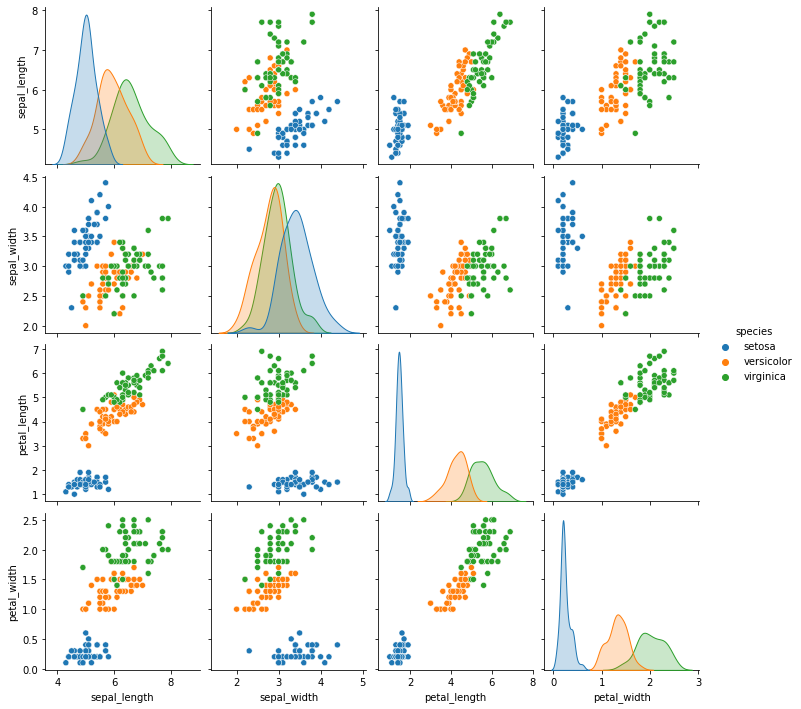

In [25]:
sns.pairplot(iris, hue='species')

Which variable looks to be the most variable between species?

### 2.4 Apply description tools to a data iterable <a name="iter"></a>

Now let's look at `iris_chunks`. If you try to look at the `head()` of this object you'll get an error because it isn't a dataframe, it's an iterable object of class `TextFileReader`:

In [26]:
iris_chunks.head()

AttributeError: ignored

You can interact with `iris_chunks` by iterating over the chunks of data in this object. Each of those chunks is a dataframe and can be accessed using the methods described above.

In [27]:
for i, chunk in enumerate(iris_chunks):
    print('Chunk {} has shape {}'.format(i, chunk.shape))

Chunk 0 has shape (10, 5)
Chunk 1 has shape (10, 5)
Chunk 2 has shape (10, 5)
Chunk 3 has shape (10, 5)
Chunk 4 has shape (10, 5)
Chunk 5 has shape (10, 5)
Chunk 6 has shape (10, 5)
Chunk 7 has shape (10, 5)
Chunk 8 has shape (10, 5)
Chunk 9 has shape (10, 5)
Chunk 10 has shape (10, 5)
Chunk 11 has shape (10, 5)
Chunk 12 has shape (10, 5)
Chunk 13 has shape (10, 5)
Chunk 14 has shape (10, 5)


If you try to iterate through the list a second time, nothing happens:

In [28]:
for i, chunk in enumerate(iris_chunks):
    print('Chunk {} has shape {}'.format(i, chunk.shape))

This is because the `iris_chunk` iterable is mutable and behaves much like a queue. Once elements from it have been accessed they are dropped from memory.

If you have a large data file that doesn't fit in memory, you can access each chunk, summarize in a meaningful way, and assign the summaries to new variables such that everything fits in memory.

We'll close our discussion of iterable dataframes and delete the `iris_chunks` variable because the tutorial will use only small data structures. You can delete variables you no longer need using the built in function `del`.

In [29]:
del iris_chunks

## 3. Clean data <a name="clean"></a>

Good models require good data.

Let's load in a new dataset, `iris_missing_data.csv`. This is a copy of `iris.csv` with a few values intentionally removed or altered so you can practice finding different types of missing or messy data.

In [30]:
iris_missing = pd.read_csv('https://raw.githubusercontent.com/kellypierce/python_data_science/master/iris_missing_data.csv')

**On your own:**

- Use the `head()` method to look at the first few rows of data.
- Use the `shape` method to determine the number of rows and columns.
- Use the `value_counts()` method to see how many observations of each species are present.
- Use the `dtypes` method to inspect the column datatypes.
- Use the `describe()` method to look at quantitative summaries of numerical columns.

Based on the results of this exploration, where do you think the missing data are?

In [31]:
iris_missing.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.1,1.5,0.1,setosa
1,4.8,3.0,1.4,0.1,setosa
2,4.3,3.0,1.1,NaN,setosa
3,5.2,4.1,1.5,0.1,setosa
4,4.9,3.6,1.4,0.1,setosa


In [32]:
iris_missing.shape

(150, 5)

In [33]:
iris_missing['species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: species, dtype: int64

In [34]:
iris_missing.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width      object
species          object
dtype: object

In [35]:
iris_missing.describe()

,sepal_length,sepal_width,petal_length
count,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000
std,0.828066,0.435866,1.765298
min,4.300000,2.000000,1.000000
25%,5.100000,2.800000,1.600000
50%,5.800000,3.000000,4.350000
75%,6.400000,3.300000,5.100000
max,7.900000,4.400000,6.900000


### 3.1 Clean messy data <a name="mess"></a>

You'll notice that the data types in `iris_missing` are not quite what we expect: the `petal_width` column data type is `object`, not `float64`. This indicates that some of the data in this column are not numeric. But when we look at the `head()` of the dataframe we see numbers (`NaN` is a numeric datatype in Python).

Before we proceed with our exploration we need to identify the non-numeric data.

The first thing we can try is to convert the values in column `petal_width` to floats:

In [36]:
iris_missing['petal_width'] = [float(i) for i in iris_missing['petal_width']]

ValueError: ignored

While this first attempt didn't work, the error helps us to locate the problem. At least one number has the letter 'o' in place of a zero. We can use string replacement to fix this, then convert the string to a float.

In [37]:
iris_missing['petal_width'] = [float(i.replace('O', '0')) if isinstance(i, str) else i for i in iris_missing['petal_width']]


No errors -- that worked! 

Let's break this line down to understand how it works:

This is a list comprehension, which is a for-loop flattened out into a single line. This code will iterate over all the values in `iris_missing['petal_width']` to perform the type conversion.

    [float(i.replace('O', 0)) if isinstance(i, str) else i for i in iris_missing['petal_width']]
    
This is the same as `for i in iris_missing['petal_width']: ...`

The "O" is removed with `i.replace('O', 0)`, which will take the string variable `i` and replace it with the number 0.

`i.replace()` won't work if `i` is actually a numeric type, because numeric types don't have a `replace()` method. Not all of the values in `iris_missing` are strings -- some are already floats. We handle this with an `if else` clause: `isinstance(i, str)` we will use the `replace()` method, `else i` means if `i` isn't a string we will just keep it as is.

The whole list comprehension returns a list, which is then assigned to be the new value of the column `iris_missing['petal_width']`.

In [38]:
iris_missing.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Now the `petal_width` column contains `float64` data, as expected.

In [39]:
iris_missing.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,140.000000
mean,5.843333,3.057333,3.758000,1.268571
std,0.828066,0.435866,1.765298,0.741580
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.400000
50%,5.800000,3.000000,4.350000,1.400000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### 3.2 Describe missing data <a name="miss"></a>

Most real world data are missing some values. Finding holes in datasets and learning how to handle them is a critical part of doing data science. Pandas offers a number of tools to help you handling missing data.

#### 3.2.1 Missing data may have meaning <a name="mean"></a>

It's possible that some types of measurements are more likely to be missed than others. If that's the case, seeing missing measurements in your dataset can tell you something useful about your data and you probably will want to retain the missing data in your analysis.

Alternatively, if the data are missing at random then they likely just represent noise and lack meaning. In this case it's appropriate to handle them using one of the techniques below.

#### 3.2.2 Missing data vs zero <a name="zero"></a>

Missing data is data that were not measured or not recorded.

Zero is a measurement of, well, zero.

Sometimes it can be hard to tell if empty cells in your dataframe are missing data (not measured) or measured as zero. You can use the context of the data to try to decide: would a measure of zero make sense?

Even if zeros would make sense for your data, be careful about assuming that any missing entry should be zero.

If you're confident that your missing data really should be zeros, you can use the `df.fillna(value=0)` method to substitute missing data with 0.

#### 3.2.3 Find rows with missing data <a name="row"></a>

We can also use the `isnull()` method, in cojunction with dataframe subsetting (also called slicing), to identify specific rows that contain missing data.

Subsetting dataframes is a technique that allows you to select specific rows based on a set of criteria you define. The criteria can be quantitative or qualitative. We'll look at one criterion for now: `isnull() == True` will help us locate rows that have null values in specific columns.

First we'll consider the `petal_width` column:

In [40]:
iris_missing[iris_missing['petal_width'].isnull() == True]

,sepal_length,sepal_width,petal_length,petal_width,species
2,4.3,3.0,1.1,NaN,setosa
7,4.7,3.2,1.3,NaN,setosa
14,5.8,4.0,1.2,NaN,setosa
25,5.0,3.2,1.2,NaN,setosa
26,5.5,3.5,1.3,NaN,setosa
27,4.4,3.0,1.3,NaN,setosa
29,4.4,3.2,1.3,NaN,setosa
38,5.0,3.5,1.3,NaN,setosa
39,4.5,2.3,1.3,NaN,setosa
43,5.4,3.9,1.3,NaN,setosa


In [41]:
iris_missing[iris_missing['sepal_length'].isnull() == True]

,sepal_length,sepal_width,petal_length,petal_width,species


Now we'll consider the remaining columns.

In [42]:
iris_missing[iris_missing['sepal_width'].isnull() == True]

,sepal_length,sepal_width,petal_length,petal_width,species


In [43]:
iris_missing[iris_missing['petal_length'].isnull() == True]

,sepal_length,sepal_width,petal_length,petal_width,species


In [44]:
iris_missing[iris_missing['species'].isnull() == True]

,sepal_length,sepal_width,petal_length,petal_width,species


We can see that 10 rows are missing `petal_width` data, but otherwise all data are present.

What can we do about the missing `petal_width` data?

#### 3.2.4 Describe the distribution of missing data <a name="distr"></a>

We can use graphs to help identify patterns in the missingness of data.

First we will make a new column that indicates whether `petal_width` data are present using a boolean (`bool`) data type:

In [45]:
iris_missing['no_petal_width'] = iris_missing['petal_width'].isnull()
iris_missing.dtypes

sepal_length      float64
sepal_width       float64
petal_length      float64
petal_width       float64
species            object
no_petal_width       bool
dtype: object

Next we will subset the dataframe into two new dataframes: one where the rows have `petal_width` values, and another where the rows do not. (This doesn't change the `iris_missing` dataframe; it makes copies of the selected rows to new variables.)

In [46]:
no_petal_width = iris_missing[iris_missing['no_petal_width'] == True]
yes_petal_width = iris_missing[iris_missing['no_petal_width'] == False]

Now we can look at the distribution of the other measurements (sepal width, sepal length, and petal length) by whether or not there is a corresponding petal width measurement.

We will use methods two plotting libraries together to make a single image with three panels:
- `matplotlib.pyplot`, which we imported as `plt`, has methods to organize the panels (subplots). We'll use `subplots()` to request the number of panels and the overall figure size.
- `seaborn`, which we imported as `sns` has a `distplot` method that makes smoothed histograms. We will use this function to populate the subplots. We'll use the argument `ax=` to tell `distplot()` which of the subplots each smoothed histogram should plot to.
- The `bins` parameter can specify the number of bins for each histogram. Most of the observations have petal widths, so we'll use `bins=10` to give those histograms 10 bins. Since there are fewer observations without petal withds, we'll use `bins=3`.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


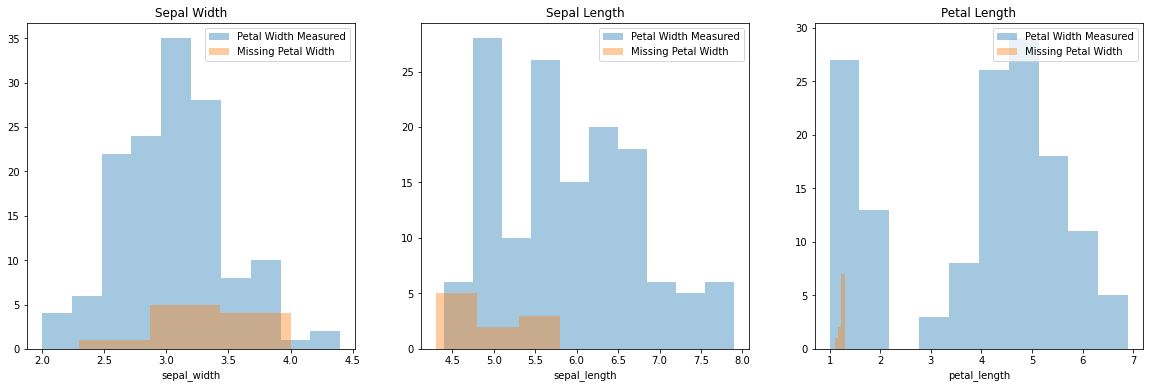

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# panel 0: sepal width
sns.distplot(yes_petal_width['sepal_width'], bins=10, hist = True, kde = False, label = 'Petal Width Measured', ax=ax[0])
sns.distplot(no_petal_width['sepal_width'], bins=3, hist = True, kde = False, label = 'Missing Petal Width', ax=ax[0])
ax[0].set_title('Sepal Width')
ax[0].legend()

# panel 1: sepal length
sns.distplot(yes_petal_width['sepal_length'], bins=10, hist = True, kde = False, label = 'Petal Width Measured', ax=ax[1])
sns.distplot(no_petal_width['sepal_length'], bins=3, hist = True, kde = False, label = 'Missing Petal Width', ax=ax[1])
ax[1].set_title('Sepal Length')
ax[1].legend()

# panel 2: petal length
sns.distplot(yes_petal_width['petal_length'], bins=10, hist = True, kde = False, label = 'Petal Width Measured', ax=ax[2])
sns.distplot(no_petal_width['petal_length'], bins=3, hist = True, kde = False, label = 'Missing Petal Width', ax=ax[2])
ax[2].set_title('Petal Length')
ax[2].legend()


Most of the observations lacking petal width data seem to come from flowers with short petals and sepals.

We can also see how missing data is distributed between the three species in the dataset. We'll use the pandas `groupby()` and `count()` methods to handle this categorial data.

In [48]:
iris_missing.groupby(['species'])['petal_width'].count().reset_index()

,species,petal_width
0,setosa,40
1,versicolor,50
2,virginica,50


We see that species `setosa` has only 40 observations of `petal_width`, which the other two species have 50 each. It seems all the data are missing from only the `setosa` species.

We can also visualize this using the `seaborn` method `countplot()`. For this graph, we'll use the data frame with the missing `petal_width` observations removed. The `countplot()` method will perform the same aggregation as the `groupby().count()` operation we did above, but will produce a barplot instead of a dataframe.

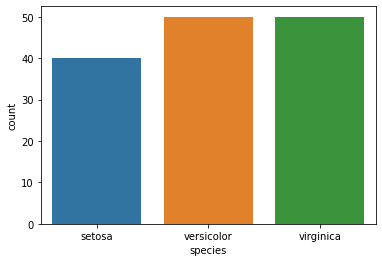

In [49]:
sns.countplot(x='species', data=yes_petal_width)

### 3.3 Handle missing data <a name="handle"></a>

There are three options for handling missing data once you've found it and described it:

A. Ignore it

B. Fill it in (interpolate)

C. Remove it

#### 3.3.1 Ignoring missing data <a name="ignore"></a>

We have pretty compelling evidence that the missing data in the `iris_missing` dataset are not randomly distributed and therefore have meaning. That makes ignoring the missing data (pretending they don't exist) unwise. But this is the easiest of all the options, because you don't have to do anything.

#### 3.3.2 Interpolate missing data <a name="interp"></a>

If your missing data are randomly distributed you can sometimes reasonably fill in the mean value (or some other meaningful measure of center, like median or the expected value of a different distribution).

We know this isn't an appropriate strategy for the `iris_missing` data, but here's what the code would look like if we wanted to fill in the missing sepal widths with the mean sepal width for the setosa species.

In [50]:
sepal_width_mean = np.mean(iris_missing[iris_missing['species'] == 'setosa']['petal_width'])
iris_filled = iris_missing.fillna(value=sepal_width_mean)
iris_filled.head()

,sepal_length,sepal_width,petal_length,petal_width,species,no_petal_width
0,4.9,3.1,1.5,0.10,setosa,False
1,4.8,3.0,1.4,0.10,setosa,False
2,4.3,3.0,1.1,0.25,setosa,True
3,5.2,4.1,1.5,0.10,setosa,False
4,4.9,3.6,1.4,0.10,setosa,False


You can see one entry where `no_petal_width` is `True` that has the mean value of 0.25 filled in.

#### 3.3.3 Remove missing data <a name="remove"></a>

The final option, and the one most suitable for our `iris_missing` data, is to remove missing data. There are a few options for removing missing data:

- By row: we can remove all rows that are missing the `petal_width` measures. This is not recommended for our data, because we know there is a pattern to our missing data. This can be done with the `dropna()` method for dataframes.
- By column: we can remove the entire `petal_width` column and only consider the other measures.
- By subset: we can remove a meaningful data subset to clear up the missing data. In the case of our `iris_missing` data, we may elect to remove all of the `setosa` species data. But since our original goal was to classify plants into the three possible species, we probably don't want to get rid of all the `setosa` data.

We will remove the `petal_width` column before we proceed. We'll use the argument `axis=1` to let pandas know this is a column we want to drop, not a row.

In [51]:
iris_drop_missing = iris_missing.drop('petal_width', axis=1)
iris_drop_missing.head()

,sepal_length,sepal_width,petal_length,species,no_petal_width
0,4.9,3.1,1.5,setosa,False
1,4.8,3.0,1.4,setosa,False
2,4.3,3.0,1.1,setosa,True
3,5.2,4.1,1.5,setosa,False
4,4.9,3.6,1.4,setosa,False


## 4. Classification Model <a name="class"></a>

Now that we've cleaned up our data, we can proceed to the main event: building a model that classifies plants into species given measurements on their flowers. Because we are classifying observations by a categorial value (species name), we will use logistic regression. Other classification techniques we won't discuss include decision trees, random forests, and support vector machines. Neural networks are also used for classification on more complex datasets, like images.

Before we get started, let's import some modules specific to this part of the tutorial:

In [52]:
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

### 4.1 Class Balance <a name="bal"></a>

It is much easier to train a classification algorithm when there are similar numbers of observations from each class. In our case, we have three species each with 50 observations. This is perfect class balance. If we had unbalanced classes, we may need to tweak the data a bit to even things out a bit.

Downsampling the majority class refers to excluding some observations from the category with the most observations. This is the most commonly used technique. 

Upsampling minority classes refers to duplicating data from categories that are underrepresented. This technique is less popular as it inflates sample size and makes your dataset appear larger than it truly is.

In either case, look to `np.random.sample()` for methods on how to randomly select data from your dataset. Once you've randomly selected data, you can discard or duplicate them as desired.

### 4.2 Standardizing Measure Scales <a name="std"></a>

Our measurements, sepal width, sepal length, and petal length, are observed on different scales:

In [53]:
iris_drop_missing.groupby('species')['sepal_width', 'sepal_length', 'petal_length'].mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,sepal_width,sepal_length,petal_length
species,,,
setosa,3.428,5.006,1.462
versicolor,2.770,5.936,4.260
virginica,2.974,6.588,5.552


Just from considering the average values by species, we see that sepal length can be much larger than sepal width or petal length. If we use the raw data, it's possible that sepal length might have more influence on the performance of the model because it has greater magnitude, even it it's not necessarily the best predictor of species.

We can standardize the values so that they are all on the same scale. We will do this using the `sklearn` function `StandardScaler.fit_transform()`. This function calculates the mean and standard deviation of each column in the data frame and then uses those values to calculate the standard score of each observation.

Before we standardize the data, we'll split the `iris_drop_missing` dataframe into `X` and `y` dataframes. The `X` dataframe will contain the measures (the x-values in our regression), and the `y` dataframe will contain the species names (the y-values we are trying to predict with our regression).

In [54]:
y = iris_drop_missing['species']
X = iris_drop_missing[['sepal_length', 'sepal_width', 'petal_length']]

In [55]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### 4.3 Multinomial Logistic Regression <a name="multi"></a>

#### 4.3.1 Fit the Model <a name="fit1"></a>

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.33, random_state=42)


In [57]:
log_reg = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')

In [58]:
model1 = log_reg.fit(X_train, y_train)

In [59]:
test_results = model1.predict(X_test)

#### 4.3.2 Evaluate the Model: Accuracy Metrics <a name="acc"></a>

In [60]:
outcomes = {
    'versicolor': {'total': 0, 'test': 0}, 
    'setosa': {'total': 0, 'test': 0}, 
    'virginica': {'total': 0, 'test': 0}}
for test, true in zip(test_results, y_test):
    outcomes[true]['total'] += 1
    if test == true:
        outcomes[true]['test'] += 1

In [61]:
in_class_accuracy = {key: val['test']/val['total'] for key, val in outcomes.items()}

In [62]:
in_class_accuracy

{'setosa': 1.0, 'versicolor': 0.9333333333333333, 'virginica': 0.875}

### 4.4 One-vs-Rest Logistic Regression <a name="ovr"></a>

#### 4.4.1 Fit the Model <a name="fit2"></a>

In [63]:
integer_classes = {
    'setosa': 0,
    'versicolor': 1,
    'virginica': 2
}

iris_drop_missing['integer_species'] = [integer_classes[sp] for sp in iris_drop_missing['species']]

In [64]:
binary_y = label_binarize(iris_drop_missing['integer_species'], classes=[0, 1, 2])

In [65]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_std, binary_y, test_size=0.33, random_state=42)

In [66]:
ovr_log_reg = OneVsRestClassifier(LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg'))

In [67]:
model2 = ovr_log_reg.fit(X_train_2, y_train_2).decision_function(X_test_2)

#### 4.4.2 Evaluate the Model: Receiver-Operator Criterion <a name="roc"></a>

Following from the `skearn` documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings

In [68]:
# Compute ROC curve and ROC area for each class
n_classes = binary_y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], model2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), model2.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

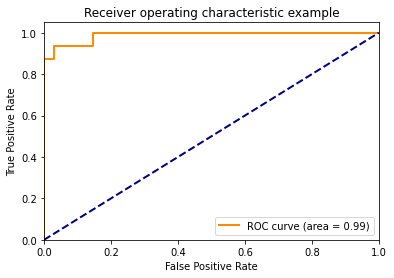

In [69]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  from ipykernel import kernelapp as app


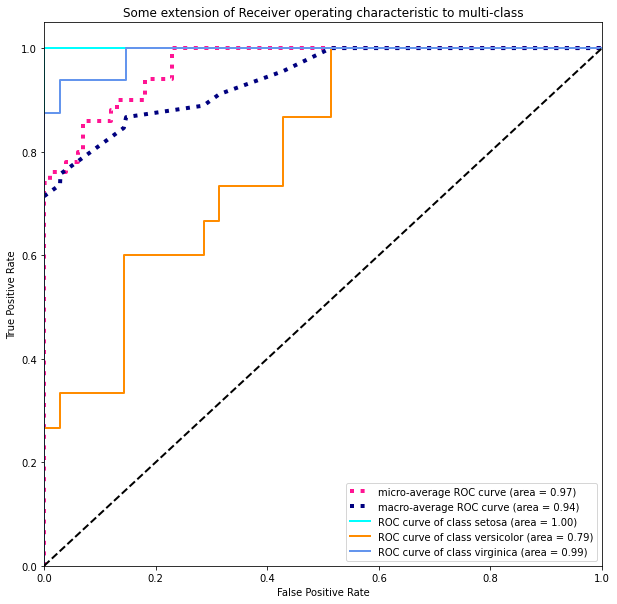

In [70]:
rev_integer_classes = {
    0: 'setosa',
    1: 'versicolor',
    2: 'virginica'
}

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(rev_integer_classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()